In [9]:
## old, remove
import torch.nn as nn

class EClassifier(nn.Module):
    def __init__(self, num_locations, embedding_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(num_locations, embedding_dim)
        self.linear = nn.Linear(embedding_dim, num_classes)
    def forward(self, x):
        # x is a tensor containing word ids
        loc_emb = self.embedding(x[:,0])
        return self.linear(torch.cat((loc_emb, x[:,1:]), 1))

In [66]:
import pandas as pd
import numpy as np
import os
from sklearn import preprocessing 
from sklearn.preprocessing import OneHotEncoder

data_dir = "../data/"
train_vals_df = pd.read_csv(os.path.join(data_dir, "train_values.csv"))
train_labels_df = pd.read_csv(os.path.join(data_dir, "train_labels.csv"))

# get categorical data
X1 = train_vals_df["geo_level_1_id"].to_numpy()

## get numerical data
df = train_vals_df[[
'count_floors_pre_eq',
'age',
'area_percentage',
'height_percentage']]

# normalize numerical data
min_max_scaler = preprocessing.MinMaxScaler()
X2 = min_max_scaler.fit_transform(df.values)


# get labels

y = train_labels_df["damage_grade"].to_numpy()
y = np.eye(3)[y-1]

X = np.concatenate((X1[:,np.newaxis],X2), axis = 1)

## Train val test split
### X1 is categorical data and X2 is numerical data

In [67]:
rng = np.random.RandomState(1)
perm = rng.permutation(range(len(X)))
X_rand = X[perm]
y_rand = y[perm]

trainIdx = int(.8*len(X))
X_train = X[:trainIdx]
y_train = y[:trainIdx]
X_val = X[trainIdx:]
y_val = y[trainIdx:]


## Create model that embeds categorical data

In [100]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense, Embedding

## Creating the layers
batch_size = 100
input = Input(shape=(5,)) 
embedding = Embedding(31, 3)(input[:,0])
Layer_1 = Dense(10, activation="relu")(tf.concat([embedding, input[:,1:]], 1))
Layer_2 = Dense(5, activation="relu")(Layer_1)
output_layer= Dense(3, activation="softmax")(Layer_2)

model = tf.keras.Model(inputs=input, outputs=output_layer, name="emb_model")
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='CategoricalCrossentropy', metrics=['CategoricalAccuracy'])
history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, validation_data=(X_val, y_val))

Epoch 1/50
2085/2085 [==============================] - 1s 562us/step - loss: 0.8590 - categorical_accuracy: 0.6216 - val_loss: 0.7630 - val_categorical_accuracy: 0.6486
Epoch 2/50
2085/2085 [==============================] - 1s 498us/step - loss: 0.7578 - categorical_accuracy: 0.6492 - val_loss: 0.7502 - val_categorical_accuracy: 0.6521
Epoch 3/50
2085/2085 [==============================] - 1s 502us/step - loss: 0.7439 - categorical_accuracy: 0.6538 - val_loss: 0.7437 - val_categorical_accuracy: 0.6537
Epoch 4/50
2085/2085 [==============================] - 1s 500us/step - loss: 0.7399 - categorical_accuracy: 0.6540 - val_loss: 0.7393 - val_categorical_accuracy: 0.6551
Epoch 5/50
2085/2085 [==============================] - 1s 498us/step - loss: 0.7356 - categorical_accuracy: 0.6565 - val_loss: 0.7380 - val_categorical_accuracy: 0.6563
Epoch 6/50
2085/2085 [==============================] - 1s 502us/step - loss: 0.7356 - categorical_accuracy: 0.6551 - val_loss: 0.7368 - val_categoric

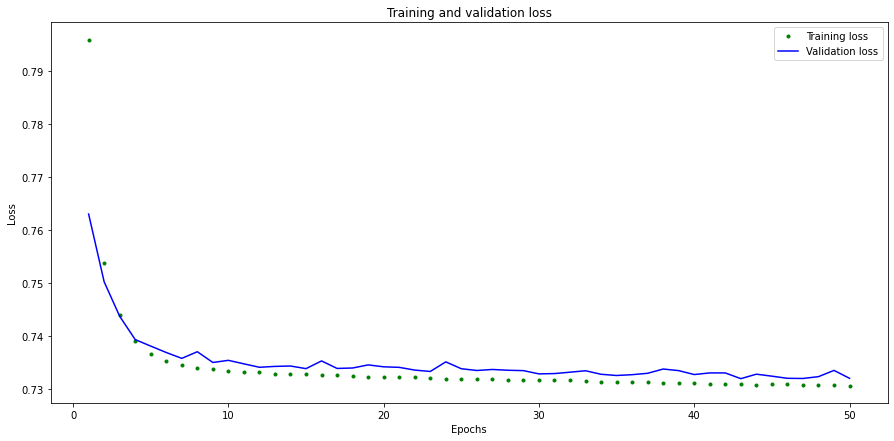

[15.0, 7.0]


In [102]:
import matplotlib.pyplot as plt

# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (15,7)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

In [101]:
predictions = model.predict(X_val)
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
predictions = model.predict(X_val)
y_pred = []
y_true = []
for i,row in enumerate(predictions):
  y_pred.append(np.argmax(row))
  y_true.append(np.argmax(y_val[i]))

f1_score(y_true, y_pred, average = 'micro')

0.659523032942576

<AxesSubplot:>

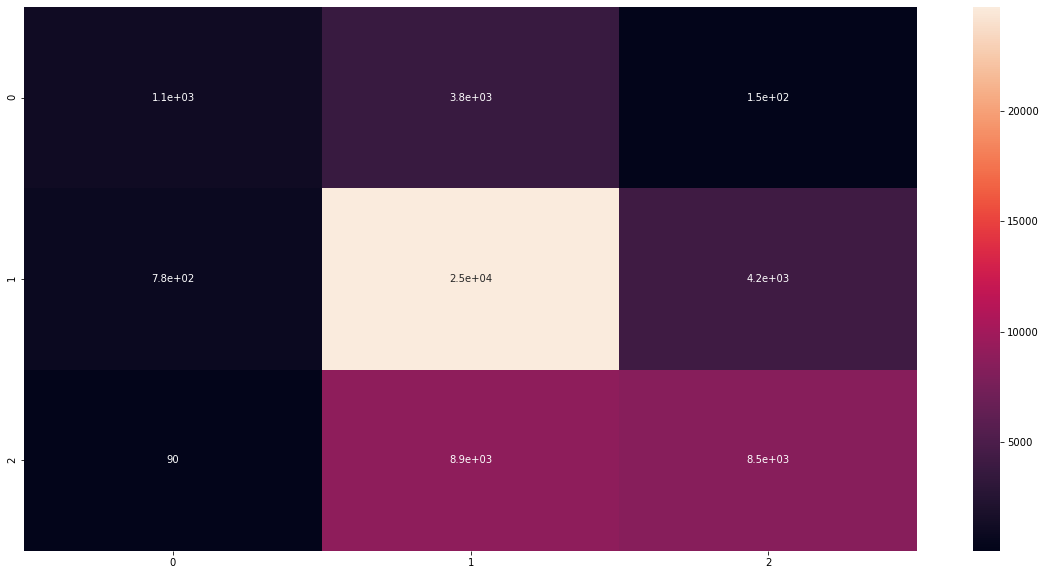

In [76]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
predictions = model.predict(X_val)
y_pred = []
y_true = []
for i,row in enumerate(predictions):
  y_pred.append(np.argmax(row))
  y_true.append(np.argmax(y_val[i]))

# print(y_pred)
# print(y_true)
confusion_matrix(y_true, y_pred)
import seaborn as sns
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True)


In [82]:
test_vals_df = pd.read_csv("../data/test_values.csv")
# get categorical data
X1 = test_vals_df["geo_level_1_id"].to_numpy()

## get numerical data
df = test_vals_df[[
'count_floors_pre_eq',
'age',
'area_percentage',
'height_percentage']]

# normalize numerical data
min_max_scaler = preprocessing.MinMaxScaler()
X2 = min_max_scaler.fit_transform(df.values)



X_test = np.concatenate((X1[:,np.newaxis],X2), axis = 1)

In [91]:
predictions = model.predict(X_test)
y_pred = []
for i,row in enumerate(predictions):
  y_pred.append(np.argmax(row) + 1)



In [96]:
submission = pd.DataFrame()
submission["building_id"] = test_vals_df["building_id"]
submission["damage_grade"] = y_pred

In [99]:
submission
submission.to_csv("embedding_model1.csv", index=False)